In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
import dalex as dx

from funs import (
    dataPreparation,
    createMetaDictionary,
    createDictionary,
    evaluateModel,
    dictionaryModel,
)

# Data preparation

## Base data

In [2]:
data = dataPreparation(
    all_trxns_path="../data/all_trxns.csv", exchange_rates_path="../data/exchange_rates.csv"
)

C:\Users\mateu\Desktop\new folder\fraud-pred\Fraud-Prediction\src\funs.py:182: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  trxns_data["timestamp"] = pd.to_datetime(


## Train Test split

In [3]:
data["fraud_flag_trans"] = data["fraud_flag"].replace({"N": 0, "Y": 1})
X = data
y = data["fraud_flag_trans"]
data = data.drop("fraud_flag_trans", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Train dictionaries

In [5]:
dictionaries_to_get = [
    "customer_country",
    "counterparty_country",
    "type",
    "ccy",
    "customer_type",
    "weekday",
    "month",
    "quarter",
    "hour",
    "amount_eur_bucket",
]

dictionaries = {}
for dict_name in dictionaries_to_get:
    dictionaries[dict_name] = createDictionary(
        X_train, colname=dict_name, count_filter=0
    )

meta_dicts = []  # Use a list to collect dictionaries
for dict_name in dictionaries_to_get:
    meta_dict = createMetaDictionary(X_train, colname=dict_name, quantile_threshold=0.9, count_filter=0)
    meta_dicts.append(meta_dict)
meta_dictionary = pd.concat(meta_dicts, ignore_index=True)

## Dictionary Model train data

In [6]:
LP_model_train = dictionaryModel(
    X_train,
    dictionaries,
    meta_dictionary,
    fraud_probability_threshold=0.18,
    sd_flags_threshold=1,
    quantile_flags_threshold=1,
)
LP_model_train = LP_model_train.drop(
    columns=["fraud_flag_transformed", "fraud_flag", "predicted_fraud"], axis=1
)

## Dictionary Model test data

In [7]:
LP_model_test = dictionaryModel(
    X_test,
    dictionaries,
    meta_dictionary,
    fraud_probability_threshold=0.18,
    sd_flags_threshold=1,
    quantile_flags_threshold=1,
)
LP_model_test = LP_model_test.drop(
    columns=["fraud_flag_transformed", "fraud_flag", "predicted_fraud"], axis=1
)

## One-hot encoding

In [8]:
model_train_data = pd.get_dummies(LP_model_train, columns=dictionaries_to_get)
model_test_data = pd.get_dummies(LP_model_test, columns=dictionaries_to_get)

## Additional cleaning

In [9]:
model_train_data.columns = [
    col.replace("[", "").replace("]", "") for col in model_train_data.columns
]
model_test_data.columns = [
    col.replace("[", "").replace("]", "") for col in model_test_data.columns
]

model_train_data.drop(["customer", "timestamp", "counterparty"], axis=1, inplace=True)
model_test_data.drop(["customer", "timestamp", "counterparty"], axis=1, inplace=True)

# XGBoost model

In [15]:
print(model_train_data)

      expected_fraud_probability  sd_flags  quantile_flags  quantile_1_flags  \
0                       0.117376       0.0             1.0               7.0   
1                       0.150738       0.0             0.0               8.0   
2                       0.100358       0.0             0.0               7.0   
3                       0.327700       4.0             4.0              10.0   
4                       0.155509       1.0             1.0               7.0   
...                          ...       ...             ...               ...   
4236                    0.176635       2.0             3.0               7.0   
4237                    0.273360       3.0             3.0              10.0   
4238                    0.226964       2.0             3.0              10.0   
4239                    0.197020       1.0             2.0               9.0   
4240                    0.155839       1.0             2.0               8.0   

      quantile_25_flags  quantile_75_fl

## Training

In [25]:
parameters = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_lambda': [1, 1.5, 3],
    'n_estimators': [300, 500, 700]
}

model_xgb = XGBClassifier(random_state=42)

grid_search = GridSearchCV(model_xgb, parameters, cv=3, scoring='accuracy')
grid_search.fit(model_train_data, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 300, 'reg_lambda': 1.5}


In [28]:
model_xgb = XGBClassifier(learning_rate=0.1, 
                          max_depth=5, 
                          n_estimators= 300,
                          reg_lambda=0.5, 
                          random_state=42)

model_xgb.fit(model_train_data, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## Testing

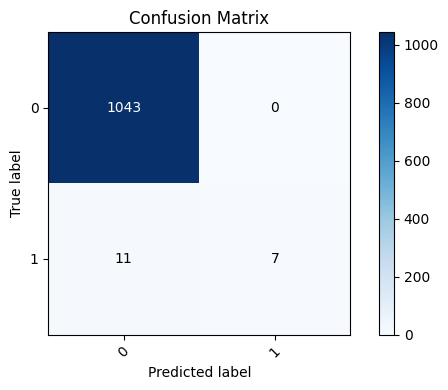


Accuracy: 98.96% 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1043
           1       1.00      0.39      0.56        18

    accuracy                           0.99      1061
   macro avg       0.99      0.69      0.78      1061
weighted avg       0.99      0.99      0.99      1061



In [29]:
y_pred = model_xgb.predict(model_test_data)
evaluateModel(y_test, y_pred)

## Explaining

In [30]:
explainer = dx.Explainer(model_xgb, model_train_data, y_train)

Preparation of a new explainer is initiated

  -> data              : 4241 rows 94 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4241 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x00000177A29DE5F0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.24e-06, mean = 0.0172, max = 0.996
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.196, mean = -1.24e-05, max = 0.391
  -> model_info        : package xgboost

A new explainer has been created!


In [32]:
explainer.model_parts().plot()

In [37]:
instance = model_train_data.iloc[0]
instance

expected_fraud_probability                   0.117376
sd_flags                                     0.000000
quantile_flags                               1.000000
quantile_1_flags                             7.000000
quantile_25_flags                            6.000000
                                               ...   
amount_eur_bucket_(99.109, 22837.588         1.000000
amount_eur_bucket_(22837.588, 43377.466      0.000000
amount_eur_bucket_(43377.466, 62376.65       0.000000
amount_eur_bucket_(62376.65, 195847.12       0.000000
amount_eur_bucket_(195847.12, 12772515.05    0.000000
Name: 0, Length: 94, dtype: float64

In [38]:
shap_values = explainer.predict_parts(instance)

In [39]:
shap_values.plot()